In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential, Model
from IPython.display import display

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from transformers import TFCamembertModel, CamembertTokenizer, CamembertConfig
config = CamembertConfig.from_pretrained("camembert-base", output_hidden_states=False)
camembert = TFCamembertModel.from_pretrained("camembert-base", config=config)
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

from matplotlib import pyplot as plt

Some layers from the model checkpoint at camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if you are initializing TFCamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFCamembertModel were not initialized from the model checkpoint at camembert-base and are newly initialized: ['roberta/pooler/dense/kernel:0', 'roberta/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
binacc = tf.keras.metrics.BinaryAccuracy()
@tf.function
def label_acc(y_true, y_pred):
    binacc.reset_state()
    binacc.update_state(y_true[:,0], y_pred[:,0])
    return binacc.result()

@tf.function
def reality_acc(y_true, y_pred):
    binacc.reset_state()
    binacc.update_state(y_true[:,1], y_pred[:,1])
    return binacc.result()

@tf.function
def label_loss(y_true, y_pred):
    loss_l = tf.keras.losses.BinaryCrossentropy()(y_true[:,0], y_pred[:,0])
    return loss_l

@tf.function
def reality_loss(y_true, y_pred):
    loss_r = tf.keras.losses.BinaryCrossentropy()(y_true[:,1], y_pred[:,1])
    return loss_r

@tf.function
def discriminator_loss(y_true, y_pred):
    loss_l = label_loss(y_true, y_pred)
    loss_r = reality_loss(y_true, y_pred)
    return ( 0.75 * loss_l ) + ( 0.5 * loss_r )

@tf.function
def generator_loss(y_true, y_pred):
    loss_l = label_loss(y_true, y_pred)
    loss_r = reality_loss(y_true, y_pred)
    return ( 0 * loss_l ) + ( 1 * loss_r )

[<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'input_noise')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_label')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='Prediction/Sigmoid:0', description="created by layer 'Prediction'")


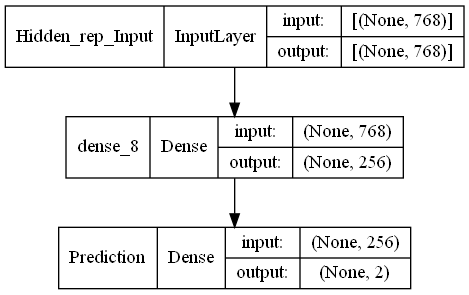

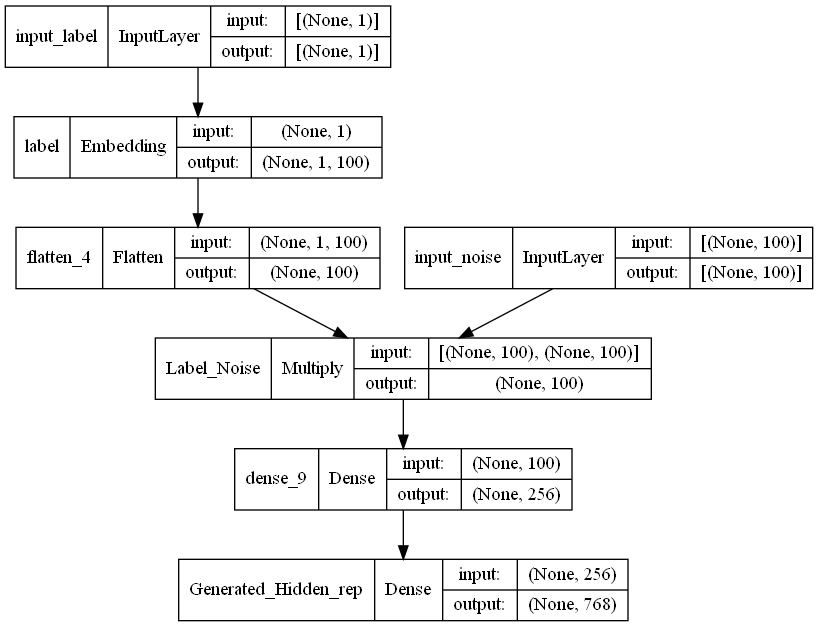

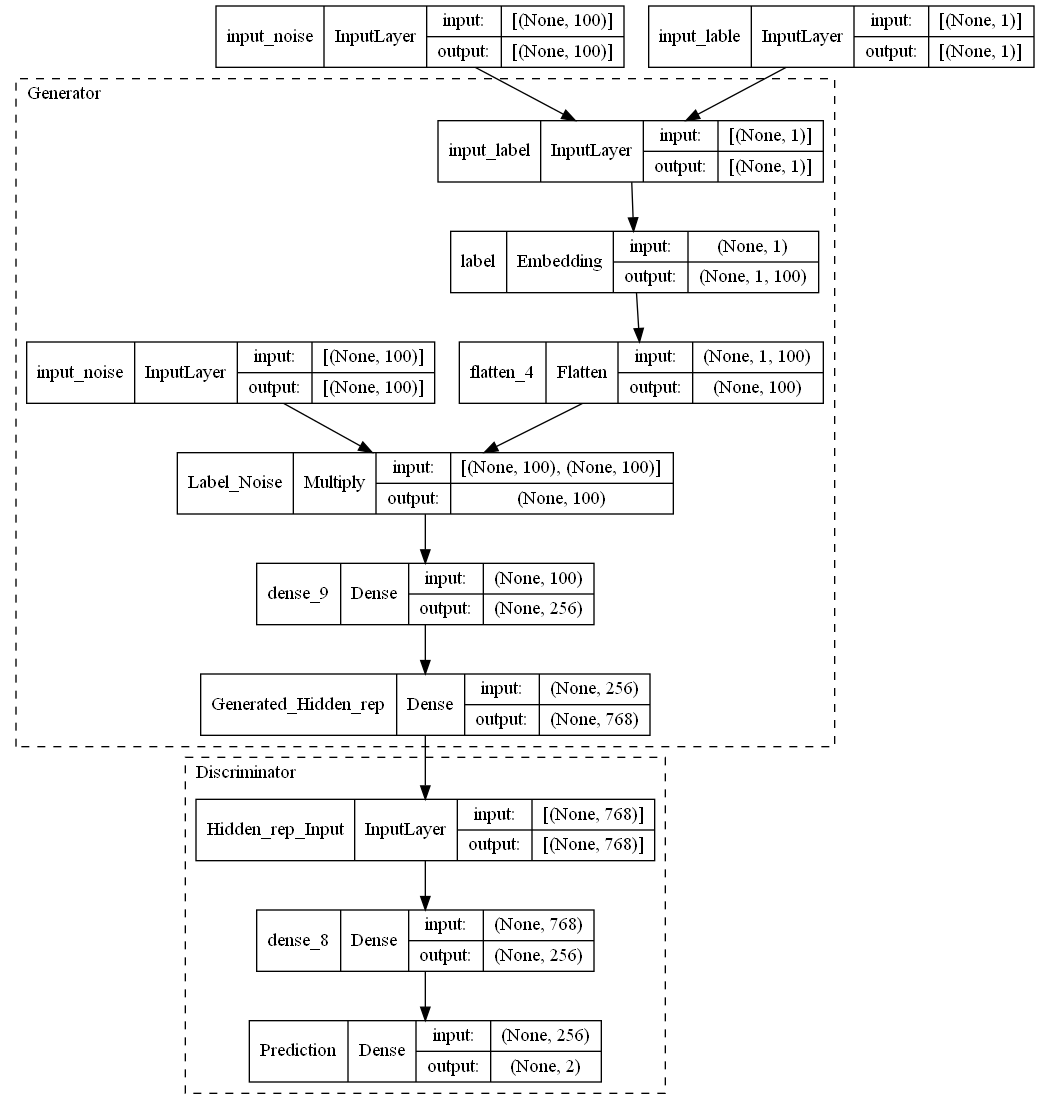

In [9]:
def generator(latent_dim):
    noise = Input(shape=(latent_dim,), name="input_noise", dtype=tf.float32)
    label = Input(shape=(1,), name="input_label", dtype=tf.float32) 
    
    label_embedding = Flatten()(Embedding(2, latent_dim, name="label")(label))
    model_input = Multiply(name="Label_Noise")([noise, label_embedding])
    
    x = Dense(256, input_dim=latent_dim)(model_input)
    out = Dense(768, name="Generated_Hidden_rep")(x)
    
    return Model([noise, label], out, name="Generator")

def discriminator():
    hidden_rep = Input(shape=(768,), dtype=tf.float32, name="Hidden_rep_Input")

    x = Dense(256)(hidden_rep)
    out = Dense(2, name="Prediction", activation="sigmoid")(x)    

    return Model(hidden_rep, out, name="Discriminator")

D = discriminator()
D.compile(loss=discriminator_loss, metrics=[label_loss, reality_loss, label_acc, reality_acc], optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001))
D.trainable = False
# display(D.summary())

latent_dim = 100
G = generator(latent_dim)
# display(G.summary())

noise = Input(shape=(latent_dim,), name="input_noise")
label = Input(shape=(1,), name="input_label")
hidden_rep = G([noise, label])
validity = D(hidden_rep)

print(G.input)
print(D.output)

# connect them
GAN = Model([noise, label], validity, name="GAN")
# GAN = Model(Ginput, validity, name="GAN")
GAN.compile(loss=generator_loss, metrics=[label_loss, reality_loss], optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001))


display(tf.keras.utils.plot_model(D, to_file="D.png", show_shapes=True, expand_nested=True, ))
display(tf.keras.utils.plot_model(G, to_file="G.png", show_shapes=True, expand_nested=True, ))
display(tf.keras.utils.plot_model(GAN, to_file="gan.png", show_shapes=True, expand_nested=True, ))

In [ ]:
display(G.summary())
display(D.summary())
display(GAN.summary())

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_123 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 label (Embedding)              (None, 1, 100)       200         ['input_123[0][0]']              
                                                                                                  
 test (InputLayer)              [(None, 100)]        0           []                               
                                                                                                  
 flatten_35 (Flatten)           (None, 100)          0           ['label[0][0]']                  
                                                                                          

None

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_rep_Input (InputLaye  [(None, 768)]            0         
 r)                                                              
                                                                 
 dense_65 (Dense)            (None, 256)               196864    
                                                                 
 Prediction (Dense)          (None, 2)                 514       
                                                                 
Total params: 197,378
Trainable params: 0
Non-trainable params: 197,378
_________________________________________________________________


None

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_124 (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 input_125 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Generator (Functional)         (None, 768)          223432      ['input_124[0][0]',              
                                                                  'input_125[0][0]']              
                                                                                                  
 Discriminator (Functional)     (None, 2)            197378      ['Generator[0][0]']            

None